In [48]:
# ============================================
# 1. IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import joblib

In [49]:
# ============================================
# 2. LOAD DATA
# ============================================
# Assume df is already loaded or do:
df = pd.read_csv("data/jobs_salaries_2023.csv")

# Load countries with region
countries = pd.read_csv("data/countries.csv")  # code,name,region

# Create feature: same_country (1 if employee and company locations match)
df["same_country"] = (
    df["employee_residence"] == df["company_location"]
).astype(int)

df = (
    df.merge(
        countries[["code", "region"]],
        left_on="company_location",
        right_on="code",
        how="left",
    )
    .rename(columns={"region": "company_region"})
    .drop(columns=["code"])

)

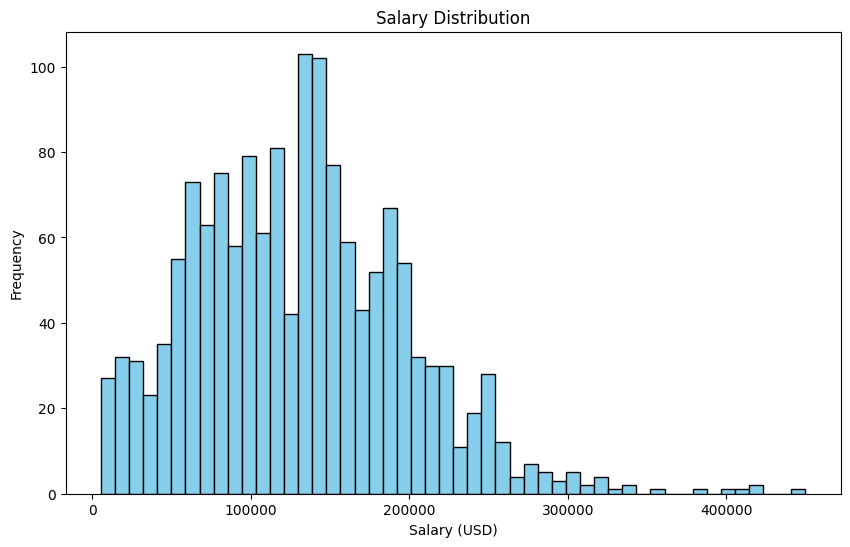

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df["salary_in_usd"], bins=50, color="skyblue", edgecolor="black")
plt.title("Salary Distribution")
plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")
plt.show()

In [51]:
categorical_cols = [
    "experience_level",
    "employment_type",
    "job_title",
    "salary_currency",
    "employee_residence",
    "company_location",
    "company_size",
]

numeric_cols = ["salary", "remote_ratio", "same_country"]

# Q1 = df["salary_in_usd"].quantile(0.25)
# Q3 = df["salary_in_usd"].quantile(0.75)
# IQR = Q3 - Q1

# # Define bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter data
# df_filtered = df[
#     (df["salary_in_usd"] >= lower_bound) & (df["salary_in_usd"] <= upper_bound)
# ]

df = df[df["salary_in_usd"] <= 300000]
print("Rows after removing salary > 300,000:", len(df))

# Keep relevant columns
df_model = df[
    [
        *categorical_cols,
        *numeric_cols,
        "salary_in_usd",
    ]
].dropna()

print(df_model.shape)
df_model.head

Rows after removing salary > 300,000: 1477
(1477, 11)


<bound method NDFrame.head of      experience_level employment_type                 job_title  \
0                  SE              FT  Principal Data Scientist   
1                  MI              CT               ML Engineer   
2                  MI              CT               ML Engineer   
3                  SE              FT            Data Scientist   
4                  SE              FT            Data Scientist   
...               ...             ...                       ...   
1494               SE              FT           Data Specialist   
1496               MI              FT  Principal Data Scientist   
1497               EN              FT            Data Scientist   
1498               EN              CT     Business Data Analyst   
1499               SE              FT      Data Science Manager   

     salary_currency employee_residence company_location company_size  \
0                EUR                 ES               ES            L   
1                US

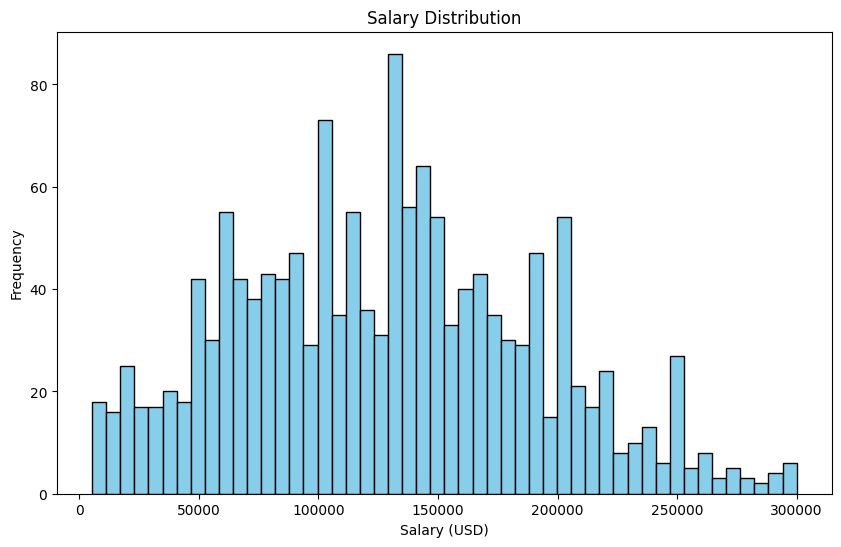

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df["salary_in_usd"], bins=50, color="skyblue", edgecolor="black")
plt.title("Salary Distribution")
plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")
plt.show()

In [53]:
# ============================================
# 3. FEATURES AND TARGET
# ============================================
X = df_model.drop(columns=["salary_in_usd"])
y = df_model["salary_in_usd"]

In [54]:
# ============================================
# 4. TRAIN/TEST SPLIT
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [55]:
# ============================================
# 5. PREPROCESSING (ONE-HOT ENCODE CATEGORICAL)
# ============================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

In [56]:
# ============================================
# 6. LINEAR REGRESSION PIPELINE
# ============================================
lr_model_combo = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

# Train model
lr_model_combo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'salary_currency',
                                                   'employee_residence',
                                                   'company_location',
                                                   'company_size']),
                                                 ('num', 'passthrough',
                                                  ['salary', 'remote_ratio',
                                                   'same_country'])])),
                ('regressor', LinearRegression())])

In [ ]:
# ============================================
# 7. EVALUATE MODEL
# ============================================
y_pred_combo = lr_model_combo.predict(X_test)

print("Combined Feature Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_combo))
print("RMSE:", root_mean_squared_error(y_test, y_pred_combo))
print("R²:", r2_score(y_test, y_pred_combo))

# ============================================
# 8. SAVE MODEL
# ============================================
joblib.dump(
    lr_model_combo, "models/linear_regression_experience_employment_location_size.pkl"
)
print("Model saved to models/linear_regression_experience_employment_location_size.pkl")

Combined Feature Linear Regression Performance:
MAE: 49782.86825928201
RMSE: 60625.230086602605
R²: 0.00036179191281793255
Model saved to models/linear_regression_experience_employment_location_size.pkl


In [58]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_estimators=200, random_state=42)),
    ]
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

joblib.dump(
    lr_model_combo, "models/random_forest_regression_experience_employment_location_size.pkl"
)
print(
    "Model saved to models/random_forest_regression_experience_employment_location_size.pkl"
)


Random Forest Performance:
MAE: 1929.478420889639
RMSE: 7281.467612157988
R²: 0.9855797134039974
Model saved to models/random_forest_regression_experience_employment_location_size.pkl


In [59]:
from sklearn.ensemble import GradientBoostingRegressor

rg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", GradientBoostingRegressor(n_estimators=200, random_state=42)),
    ]
)

rg_model.fit(X_train, y_train)
y_pred_rf = rg_model.predict(X_test)

print("\Gradient Boosting Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

joblib.dump(
    lr_model_combo,
    "models/gradient_boosting_regression_experience_employment_location_size.pkl",
)
print(
    "Model saved to models/gradient_boosting_regression_experience_employment_location_size.pkl"
)

\Gradient Boosting Performance:
MAE: 2247.1813335584297
RMSE: 7887.8974852723795
R²: 0.9830777322246349
Model saved to models/gradient_boosting_regression_experience_employment_location_size.pkl


<>:13: SyntaxWarning: invalid escape sequence '\G'
<>:13: SyntaxWarning: invalid escape sequence '\G'
/var/folders/jh/z981c7zj0vz0gmyfc8mhdxdr0000gn/T/ipykernel_59846/2305514778.py:13: SyntaxWarning: invalid escape sequence '\G'
  print("\Gradient Boosting Performance:")


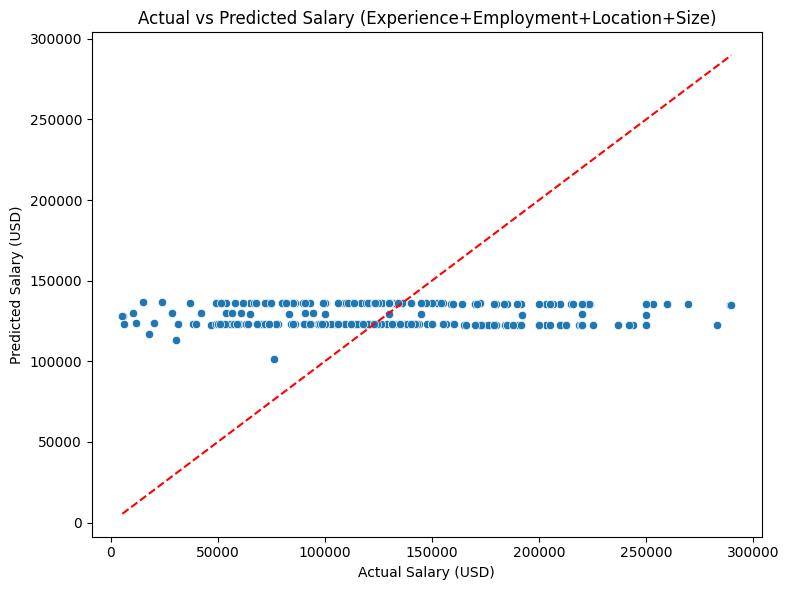

In [60]:
# ============================================
# 9. VISUALIZE: ACTUAL vs PREDICTED
# ============================================
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_combo)
plt.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--"
)  # Perfect prediction line
plt.title("Actual vs Predicted Salary (Experience+Employment+Location+Size)")
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.tight_layout()
plt.show()